In [ ]:
## 1 Multicollinearity

In [ ]:
## 2 Analyzing RCT data with Precision Adjustment

In [1]:
import Pkg
Pkg.add("DataFrames")
Pkg.add("FilePaths")
Pkg.add("Queryverse")
Pkg.add("GLM")
Pkg.add("StatsModels")
Pkg.add("Combinatorics")
Pkg.add("Iterators")
Pkg.add("CategoricalArrays")
Pkg.add("StatsBase")
Pkg.add("Lasso")
Pkg.add("TypedTables")
Pkg.add("MacroTools")
Pkg.add("NamedArrays")
Pkg.add("DataTables")
Pkg.add("Latexify")
Pkg.add("PrettyTables")
Pkg.add("TypedTables")
Pkg.add("TexTables")
Pkg.add("StatsModels")
Pkg.add("DataTables")
Pkg.add("FilePaths")
Pkg.add("Combinatorics")
Pkg.add("CategoricalArrays")
Pkg.add("TypedTables")
Pkg.add("MacroTools")

using GLM, StatsModels
using DataTables
using DelimitedFiles, DataFrames, Lasso
using FilePaths
using StatsModels, Combinatorics
using CategoricalArrays
using StatsBase, Statistics
using TypedTables
using MacroTools
using NamedArrays
using PrettyTables # Dataframe or Datatable to latex
using TexTables # pretty regression table and tex outcome

   Resolving package versions...
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`
   Resolvi

LoadError: The following package names could not be resolved:
 * Iterators (not found in project, manifest or registry)
[36m   Suggestions:[39m [0m[1mI[22m[0m[1mt[22m[0m[1me[22m[0m[1mr[22m[0m[1ma[22m[0m[1mt[22m[0m[1mo[22m[0m[1mr[22m[0m[1mS[22mampling Tar[0m[1mI[22m[0m[1mt[22m[0m[1me[22m[0m[1mr[22m[0m[1ma[22m[0m[1mt[22m[0m[1mo[22m[0m[1mr[22m[0m[1ms[22m Batch[0m[1mI[22m[0m[1mt[22m[0m[1me[22m[0m[1mr[22m[0m[1ma[22m[0m[1mt[22m[0m[1mo[22m[0m[1mr[22m[0m[1ms[22m Merged[0m[1mI[22m[0m[1mt[22m[0m[1me[22m[0m[1mr[22m[0m[1ma[22m[0m[1mt[22m[0m[1mo[22m[0m[1mr[22m[0m[1ms[22m

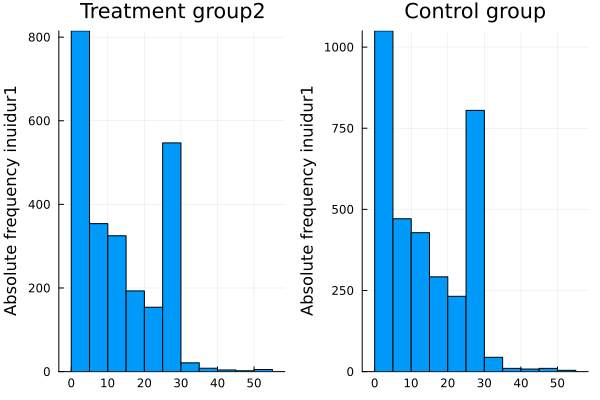

In [2]:
#----------------------#
#---Data cleaning------#
#----------------------#
using DelimitedFiles
using DataFrames

mat, head = readdlm("../../data/penn_jae.dat", header=true, Float64)
mat
df =DataFrame(mat, vec(head))
size(df)                            #13913 obs.; 23 variables

describe(df)                        #describe gives 23 rows (variables) and 7 columns giving information about the variables: name, mean, min, median, etc. 
describe(DataFrame(dep = df.dep))
describe(select(df, [:tg, :dep, :inuidur1]))   #y = inuidur1: outcome variable


#---Filter and label---#
df = filter(row -> row[:tg] in [0,2], df)
describe(select(df, :tg))  #only control group tg=0 and treatment group2 tg=2

replace!(df.tg, 2 => 1) 
rename!(df, :tg => :T2)  #Gen T2 dummy for treatment group2


#---Dep -> Categorical Variable---#
df[!,:dep] = string.(df[!,:dep])
using CategoricalArrays
df[!,:dep] = categorical(df[!,:dep]) 

describe(select(df, :dep))  #Now a categorical variable


#---Histogram for Outcome---#
using Plots

A = filter(row -> row[:T2]==1, df)  #Treatment
B = filter(row -> row[:T2]==0, df)  #Control

histogram(A[:,:inuidur1])
histogram(B[:,:inuidur1])
#histogram(df[:,:inuidur1])

plot(
    histogram(A[:,:inuidur1], ylabel="Absolute frequency inuidur1", title="Treatment group2", legend=:none),
    histogram(B[:,:inuidur1], ylabel="Absolute frequency inuidur1", title="Control group", legend=:none),
    layout=(1,2)
)

In [ ]:
#JUST FOR REFERENCE
#describe(df)
#println(names(df)) 
#["abdt", "T2", "inuidur1", "inuidur2", "female", "black", "hispanic", "othrace", "dep", "q1", "q2", "q3", "q4", "q5", "q6", "recall", "agelt35", "agegt54", "durable", "nondurable", "lusd", "husd", "muld"]

#### 2.1 CL (difference in means)

In [3]:
#----------------------------#
#---Difference in means------#  (CL)
#----------------------------#
using StatsModels
using GLM
using TexTables

ols_cl = lm(@formula(log(inuidur1) ~ T2), df)
table1 = regtable( "No adjustment model" => ols_cl)

            | No adjustment model 
            |         (1)         
----------------------------------
(Intercept) |            2.057*** 
            |             (0.021) 
         T2 |            -0.079** 
            |             (0.032) 
----------------------------------
          N |                5782 
      $R^2$ |               0.001 


#### 2.2 CRL (adding covariates)

In [4]:
#--------------------------#
#---Adding covariates------#  (CRL)
#--------------------------#
using StatsModels
using GLM
using TexTables

#using Combinatorics
# couples variables combinations 
#combinations_upto(x, n) = Iterators.flatten(combinations(x, i) for i in 1:n)
# combinations without same couple
#expand_exp(args, deg::ConstantTerm) =
#    tuple(((&)(terms...) for terms in combinations_upto(args, deg.n))...)
#StatsModels.apply_schema(t::FunctionTerm{typeof(^)}, sch::StatsModels.Schema, ctx::Type) =
#    apply_schema.(expand_exp(t.args_parsed...), Ref(sch), ctx)                                       !!DOESN'T WORK

#reg2 = @formula(log(inuidur1) ~ T2 + (female+black+othrace+dep+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)^2)
#reg2 = apply_schema(reg2, schema(reg2, df))
#ols_cra = lm(reg2, df)
#table2 = regtable("CRA model" => ols_cra)


reg1 = @formula(log(inuidur1) ~ T2 + (female*black + female*othrace + female*dep + female*q2 + female*q3 + female*q4 + female*q5 + female*q6 + female*agelt35 + female*agegt54 + female*durable + female*lusd + female*husd + black*othrace + black*dep + black*q2 + black*q3 + black*q4 + black*q5 + black*q6 + black*agelt35 + black*agegt54 + black*durable + black*lusd + black*husd + othrace*dep + othrace*q2 + othrace*q3 + othrace*q4 + othrace*q5 + othrace*q6 + othrace*agelt35 + othrace*agegt54 + othrace*durable + othrace*lusd + othrace*husd + dep*q2 + dep*q3 + dep*q4 + dep*q5 + dep*q6 + dep*agelt35 + dep*agegt54 + dep*durable + dep*lusd + dep*husd + q2*q3 + q2*q4 + q2*q5 + q2*q6 + q2*agelt35 + q2*agegt54 + q2*durable + q2*lusd + q2*husd + q3*q4 + q3*q5 + q3*q6 + q3*agelt35 + q3*agegt54 + q3*durable + q3*lusd + q3*husd + q4*q5 + q4*q6 + q4*agelt35 + q4*agegt54 + q4*durable + q4*lusd + q4*husd + q5*q6 + q5*agelt35 + q5*agegt54 + q5*durable + q5*lusd + q5*husd + q6*agelt35 + q6*agegt54 + q6*durable + q6*lusd + q6*husd + agelt35*agegt54 + agelt35*durable + agelt35*lusd + agelt35*husd + agegt54*durable + agegt54*lusd + agegt54*husd + durable*lusd + durable*husd + lusd*husd))
#(!!) I asked ChatGPT to give me the explicit formula with all interactions. I aslo ran the code with the explicit formula on lab3 with T4 to check
#if results were the same (they were). 

ols_crl = lm(reg1, df)
table2 = regtable( "CRA Model" => ols_crl)
# T2 |  -0.071** (0.032)

                   | CRA Model 
                   |    (1)    
-------------------------------
       (Intercept) |  2.447*** 
                   |   (0.381) 
                T2 |  -0.071** 
                   |   (0.032) 
            female | -0.943*** 
                   |   (0.314) 
             black | -0.508*** 
                   |   (0.146) 
           othrace |    -0.039 
                   |   (1.140) 
          dep: 1.0 |     0.280 
                   |   (0.451) 
          dep: 2.0 |     0.168 
                   |   (0.394) 
                q2 |     0.027 
                   |   (0.385) 
                q3 |    -0.354 
                   |   (0.384) 
                q4 |    -0.338 
                   |   (0.384) 
                q5 |    -0.178 
                   |   (0.383) 
                q6 |    -0.446 
                   |   (0.381) 
           agelt35 |    -0.326 
                   |   (0.326) 
           agegt54 |    -0.155 
                   |   (0.580) 
        

#### 2.3 IRA (treatment interactions)

In [5]:
#------------------------------#
#---Heterogeneous Effects------#  (IRA)
#------------------------------#
using StatsModels
using GLM
using TexTables
using Statistics

# demean function
function desv_mean(a)
    A = mean(a, dims = 1)
    M = zeros(Float64, size(X,1), size(X,2))
    
    for i in 1:size(a,2)
          M[:,i] = a[:,i] .- A[i]
    end
    return M
end    

#reg1 = @formula(T2 ~ (female+black+othrace+dep+q2+q3+q4+q5+q6+agelt35+agegt54+durable+lusd+husd)^2)
reg = @formula(T2 ~ ((female*black + female*othrace + female*dep + female*q2 + female*q3 + female*q4 + female*q5 + 
            female*q6 + female*agelt35 + female*agegt54 + female*durable + female*lusd + female*husd + black*othrace + 
            black*dep + black*q2 + black*q3 + black*q4 + black*q5 + black*q6 + black*agelt35 + black*agegt54 + black*durable + 
            black*lusd + black*husd + othrace*dep + othrace*q2 + othrace*q3 + othrace*q4 + othrace*q5 + othrace*q6 + 
            othrace*agelt35 + othrace*agegt54 + othrace*durable + othrace*lusd + othrace*husd + dep*q2 + dep*q3 + dep*q4 + 
            dep*q5 + dep*q6 + dep*agelt35 + dep*agegt54 + dep*durable + dep*lusd + dep*husd + q2*q3 + q2*q4 + q2*q5 + q2*q6 + 
            q2*agelt35 + q2*agegt54 + q2*durable + q2*lusd + q2*husd + q3*q4 + q3*q5 + q3*q6 + q3*agelt35 + q3*agegt54 + 
            q3*durable + q3*lusd + q3*husd + q4*q5 + q4*q6 + q4*agelt35 + q4*agegt54 + q4*durable + q4*lusd + q4*husd + q5*q6 +
            q5*agelt35 + q5*agegt54 + q5*durable + q5*lusd + q5*husd + q6*agelt35 + q6*agegt54 + q6*durable + q6*lusd + q6*husd +
            agelt35*agegt54 + agelt35*durable + agelt35*lusd + agelt35*husd + agegt54*durable + agegt54*lusd + agegt54*husd + 
            durable*lusd + durable*husd + lusd*husd)))

# Matrix Model & demean
X = StatsModels.modelmatrix(reg.rhs, df) 
X = desv_mean(X) # matrix format            #Take all covariates & interactions (other that T2) and demean them 

#size(X) #(5782, 119)

5782×119 Matrix{Float64}:
 -0.400726  -0.118817  -0.00518852  -0.116569  …  -0.0549983  -0.0290557  0.0
 -0.400726  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
 -0.400726  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
 -0.400726  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
 -0.400726  -0.118817  -0.00518852   0.883431  …   0.945002   -0.0290557  0.0
  0.599274  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852   0.883431     -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852   0.883431     -0.0549983  -0.0290557  0.0
 -0.400726  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852  -0.116569  …  -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852  -0.116569     -0.0549983  -0.0290557  0.0
  0.599274  -0.118817  -0.00518852  -0

In [6]:
Y = select(df, [:inuidur1,:T2]) # select inuidur1 y T4
X2 = DataFrame(hcat(X, Matrix(select(df, [:T2])).*X), :auto)  # Joint X, (T4*X)
df2 = hcat(Y, X2)  #Dataframe with outcome; T2; all other covariates with their interactions including interactions with T2
df2.inuidur1 = log.(df2.inuidur1) 

terms = term.(names(df2))           #get variables as terms ( no need for @formula() )
reg3 = terms[1] ~ sum(terms[2:end])

ols_ira  = lm(reg3, df2)
table3 = regtable("Interactive model" => ols_ira)

            | Interactive model 
            |        (1)        
--------------------------------
(Intercept) |          2.057*** 
            |           (0.021) 
         T2 |          -0.072** 
            |           (0.032) 
         x1 |            -0.666 
            |           (0.445) 
         x2 |         -0.863*** 
            |           (0.270) 
         x3 |            -1.735 
            |           (2.173) 
         x4 |             0.036 
            |           (0.685) 
         x5 |             0.212 
            |           (0.497) 
         x6 |             0.000 
            |             (NaN) 
         x7 |          -0.367** 
            |           (0.150) 
         x8 |            -0.225 
            |           (0.154) 
         x9 |            -0.117 
            |           (0.149) 
        x10 |           -0.422* 
            |           (0.225) 
        x11 |            -0.678 
            |           (0.435) 
        x12 |            -0.304 
          

In [7]:
reg1 = @formula(log(inuidur1) ~ T2 + (female*black + female*othrace + female*dep + female*q2 + female*q3 + female*q4 + female*q5 + female*q6 + female*agelt35 + female*agegt54 + female*durable + female*lusd + female*husd + black*othrace + black*dep + black*q2 + black*q3 + black*q4 + black*q5 + black*q6 + black*agelt35 + black*agegt54 + black*durable + black*lusd + black*husd + othrace*dep + othrace*q2 + othrace*q3 + othrace*q4 + othrace*q5 + othrace*q6 + othrace*agelt35 + othrace*agegt54 + othrace*durable + othrace*lusd + othrace*husd + dep*q2 + dep*q3 + dep*q4 + dep*q5 + dep*q6 + dep*agelt35 + dep*agegt54 + dep*durable + dep*lusd + dep*husd + q2*q3 + q2*q4 + q2*q5 + q2*q6 + q2*agelt35 + q2*agegt54 + q2*durable + q2*lusd + q2*husd + q3*q4 + q3*q5 + q3*q6 + q3*agelt35 + q3*agegt54 + q3*durable + q3*lusd + q3*husd + q4*q5 + q4*q6 + q4*agelt35 + q4*agegt54 + q4*durable + q4*lusd + q4*husd + q5*q6 + q5*agelt35 + q5*agegt54 + q5*durable + q5*lusd + q5*husd + q6*agelt35 + q6*agegt54 + q6*durable + q6*lusd + q6*husd + agelt35*agegt54 + agelt35*durable + agelt35*lusd + agelt35*husd + agegt54*durable + agegt54*lusd + agegt54*husd + durable*lusd + durable*husd + lusd*husd))
X = StatsModels.modelmatrix(reg1.rhs, df)  #reg2 in lab is reg1 here
X3 = desv_mean(X)

D = DataFrame([X3[:,1]], :auto)  # Treatment varaible
rename!(D, Dict(:x1 => :T2)) #rename x1 -> T2
X3 = DataFrame(hcat(X3[:,2:end], X3[:,1].*X3[:,2:end]), :auto)  # Join Controls (X) + T4*X "interactive"

Y = select(df, [:inuidur1]) #select just inuidur1
Y.inuidur1 = log.(Y.inuidur1)  # log(inuidur1)

5782-element Vector{Float64}:
 2.8903717578961645
 1.9459101490553132
 0.0
 3.295836866004329
 2.995732273553991
 3.295836866004329
 3.295836866004329
 2.1972245773362196
 3.295836866004329
 3.295836866004329
 2.70805020110221
 1.0986122886681098
 3.332204510175204
 ⋮
 2.302585092994046
 2.995732273553991
 3.295836866004329
 3.295836866004329
 2.70805020110221
 0.0
 3.1354942159291497
 1.791759469228055
 2.6390573296152584
 2.1972245773362196
 1.3862943611198906
 3.295836866004329

#### 2.4 Lasso 

In [8]:
#-----------------------#
#---IRA with Lasso------#
#-----------------------#
#names(X3)
#import Pkg; Pkg.add("HDMjl")
#using HDMjl                             #This wasn't working

   Resolving package versions...
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`


In [26]:
#-----------------------#
#---IRA with Lasso------#
#-----------------------#
import Pkg; Pkg.add("Tables"); Pkg.add("TableOperations"); Pkg.add("FreqTables")
using TableOperations
using FreqTables
using Tables
using GLM, StatsModels
using DataTables
using DelimitedFiles, DataFrames, Lasso
using FilePaths
using StatsModels, Combinatorics
using CategoricalArrays
using StatsBase, Statistics
using TypedTables
using MacroTools
using NamedArrays
using PrettyTables # Dataframe or Datatable to latex
using TexTables # pretty regression table and tex outcome
using Distributions
include("../julia_notebooks/hdmjl/hdmjl.jl")

   Resolving package versions...
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  No Changes to `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`
   Resolving package versions...
   Installed FreqTables ─ v0.4.6
    Updating `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Project.toml`
  [da1fdf0e] + FreqTables v0.4.6
    Updating `C:\Users\ALBERTO TRELLES\.julia\environments\v1.10\Manifest.toml`
  [da1fdf0e] + FreqTables v0.4.6
Precompiling project...
  ✓ FreqTables
  1 dependency successfully precompiled in 4 seconds. 334 already precompiled. 8 skipped during auto due to previous errors.


In [27]:
D_reg_0  = rlasso_arg( X3, D, nothing, true, true, true, false, false, nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true)   #`rlasso_arg` not defined
#UndefVarError: `rlasso_arg` not defined | for some reason we have this error 


rlasso_arg(5782×238 DataFrame
  Row │ x1         x2         x3           x4         x5         x6         x7 ⋯
      │ Float64    Float64    Float64      Float64    Float64    Float64    Fl ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ -0.400726  -0.118817  -0.00518852  -0.116569   0.839329  -0.200104  -0 ⋯
    2 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104   0
    3 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    4 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    5 │  0.599274  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0 ⋯
    6 │ -0.400726  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0
    7 │  0.599274  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    8 │  0.599274  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0
    9 │  0.599274  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0 ⋯
   10 │ -0

In [29]:
D_resid = rlasso(D_reg_0)

Dict{String, Any} with 19 entries:
  "tss"          => 1408.42
  "dev"          => [-0.419924, 0.580076, -0.419924, -0.419924, 0.580076, -0.41…
  "model"        => [-0.400726 -0.118817 … 0.0121229 0.0; -0.400726 -0.118817 ……
  "loadings"     => [0.24169 0.159136 … 0.0430841 0.0]
  "sigma"        => [0.493589]
  "lambda0"      => 679.639
  "lambda"       => 238×2 DataFrame…
  "intercept"    => 9.89254e-17
  "Xy"           => [-14.9637, -8.48772, -1.59772, 12.9713, -7.1093, -15.852, -…
  "iter"         => 4
  "residuals"    => [-0.419924, 0.580076, -0.419924, -0.419924, 0.580076, -0.41…
  "rss"          => 1408.42
  "index"        => [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, …
  "beta"         => 238×2 DataFrame…
  "options"      => Dict{String, Any}("intercept"=>true, "post"=>true, "meanx"=…
  "x1"           => Matrix{Float64}(undef, 5782, 0)
  "pen"          => Dict{String, Any}("lambda0"=>679.639, "lambda"=>[164.262; 1…
  "startingval"  => [-0.419924, 0.580076, -0.419

In [30]:
D_resid = rlasso(D_reg_0)["residuals"]

5782-element Vector{Float64}:
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  ⋮
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555

In [33]:
Y_reg_0  = rlasso_arg( X3, Y, nothing, true, true, true, false, false, 
                    nothing, 1.1, nothing, 5000, 15, 10^(-5), -Inf, true, Inf, true )

rlasso_arg(5782×238 DataFrame
  Row │ x1         x2         x3           x4         x5         x6         x7 ⋯
      │ Float64    Float64    Float64      Float64    Float64    Float64    Fl ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │ -0.400726  -0.118817  -0.00518852  -0.116569   0.839329  -0.200104  -0 ⋯
    2 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104   0
    3 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    4 │ -0.400726  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    5 │  0.599274  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0 ⋯
    6 │ -0.400726  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0
    7 │  0.599274  -0.118817  -0.00518852  -0.116569  -0.160671  -0.200104  -0
    8 │  0.599274  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0
    9 │  0.599274  -0.118817  -0.00518852   0.883431  -0.160671  -0.200104  -0 ⋯
   10 │ -0

In [34]:
Y_resid = rlasso(Y_reg_0)["residuals"]

5782-element Vector{Float64}:
  0.7317507898950092
 -0.05384734053849548
 -2.158620968001155
  1.137215898003174
  0.8371113055528355
  0.9765378557198169
  0.9765378557198169
 -0.12207443294829268
  1.137215898003174
  1.137215898003174
  0.5494292331010547
 -1.0600086793330457
  1.0129054998906915
  ⋮
  0.3028276034002372
  0.9959747839601821
  1.2960793764105205
  1.137215898003174
  0.886137646436092
 -1.9997574895938086
  1.321866894589781
 -0.36686149877310037
  0.8254300082758896
  0.19746708774241087
 -0.9330046491646217
  0.9765378557198169

In [35]:
D_resid = reshape(D_resid, length(D_resid), 1)

5782×1 Matrix{Float64}:
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  ⋮
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555
  0.5800760982359044
 -0.41992390176409555

In [36]:
Lasso_ira = lm(D_resid, Y_resid)   #FWL theorem

LinearModel{GLM.LmResp{Vector{Float64}}, GLM.DensePredChol{Float64, CholeskyPivoted{Float64, Matrix{Float64}, Vector{Int64}}}}:

Coefficients:
──────────────────────────────────────────────────────────────────
         Coef.  Std. Error      t  Pr(>|t|)  Lower 95%   Upper 95%
──────────────────────────────────────────────────────────────────
x1  -0.0745733   0.0320861  -2.32    0.0202  -0.137474  -0.0116724
──────────────────────────────────────────────────────────────────


In [ ]:
#### Comparing results

In [37]:
table = NamedArray(zeros(4, 5))

4×5 Named Matrix{Float64}
A ╲ B │   1    2    3    4    5
──────┼────────────────────────
1     │ 0.0  0.0  0.0  0.0  0.0
2     │ 0.0  0.0  0.0  0.0  0.0
3     │ 0.0  0.0  0.0  0.0  0.0
4     │ 0.0  0.0  0.0  0.0  0.0

In [39]:
# Comparative ATE estimation

table = NamedArray(zeros(4, 5))

table[1,2] = GLM.coeftable(ols_cl).cols[1][2]
table[2,2] = GLM.coeftable(ols_cl).cols[2][2]
table[3,2] = GLM.coeftable(ols_cl).cols[5][2]
table[4,2] = GLM.coeftable(ols_cl).cols[6][2]
table[1,3] = GLM.coeftable(ols_crl).cols[1][2]
table[2,3] = GLM.coeftable(ols_crl).cols[2][2]
table[3,3] = GLM.coeftable(ols_crl).cols[5][2]
table[4,3] = GLM.coeftable(ols_crl).cols[6][2]
table[1,4] = GLM.coeftable(ols_ira).cols[1][2]
table[2,4] = GLM.coeftable(ols_ira).cols[2][2]
table[3,4] = GLM.coeftable(ols_ira).cols[5][2]
table[4,4] = GLM.coeftable(ols_ira).cols[6][2]
table[1,5] = GLM.coeftable(Lasso_ira).cols[1][1]
table[2,5] = GLM.coeftable(Lasso_ira).cols[2][1]
table[3,5] = GLM.coeftable(Lasso_ira).cols[5][1]
table[4,5] = GLM.coeftable(Lasso_ira).cols[6][1]

T = DataFrame(table, [ :"Outcome", :"CL", :"CRA", :"IRA", :"IRA W Lasso"])  # table to dataframe 
T[!,:Outcome] = string.(T[!,:Outcome])  # string - first column 

T[1,1] = "Estimation"
T[2,1] = "Standar error"
T[3,1] = "Lower bound CI"
T[4,1] = "Upper bound CI"

header = (["Outcome", "CL", "CRA", "IRA", "IRA W Lasso"])

pretty_table(T; backend = Val(:html), header = header, formatters=ft_round(4), alignment=:c)

Outcome,CL,CRA,IRA,IRA W Lasso
Estimation,-0.0788,-0.0712,-0.0724,-0.0746
Standar error,0.0325,0.0321,0.0323,0.0321
Lower bound CI,-0.1425,-0.1341,-0.1356,-0.1375
Upper bound CI,-0.0152,-0.0083,-0.0092,-0.0117


In [ ]:
## 3 A Crash Course in Good and Bad Controls

In [ ]:
import Pkg
Pkg.add("DataFrames")
Pkg.add("Random")
Pkg.add("GLM")
Pkg.add("TexTables")
using DataFrames
using Random 
using GLM
using TexTables